# Jupyter notebook for downloading Swarm data.

Author: Maximilian Gregorius

Swarm is ESA's first constellation mission to survey Earth's magnetic and electric field and their temporal variations. It launched in 2013 and consits of three sattelites, called Alpha(A), Bravo(B) and Charlie(C) and is planned to continue the survey until 2025. A basic overview of the mission can be found at https://earth.esa.int/eogateway/missions/swarm.

In this notebook we will use the data retrival system VirES to get access to a vast amount of data inluding many of ESA’s Earth Explorer missions, Aeolus and most importantly Swarm. This data is available for many different collections of measurements and auxiliary measurements and associated models including the magnetic field, electric field, ion temperature, sattelite positions and many more. A more experienced use might use this data to calculate and visualize Earth's magnetic field or do simple space weather forecasting, but in this notebook we will focus mainly on getting access to the data and how to download some magnetic field data. The goal is to get the user familiarized with the VirEs environment and working with Swarm data so they can modify it in the future for their own needs. Some basic understanding of geomagnetism is advised but not necessary and anyone willing to learn can check out the ressources below to deepen their understanding.

Information on the data retrival system VirES can be found at https://viresclient.readthedocs.io/en/latest/.

Information on all the different collections and measurements can be found at https://viresclient.readthedocs.io/en/latest/available_parameters.html.

Understanding Earth's geomagnetic sources: https://link.springer.com/journal/11214/volumes-and-issues/206-1.

In [1]:
# Instal modules
!pip install viresclient
#conda install -c conda-forge viresclient

In [2]:
# Import modules
from viresclient import SwarmRequest
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time

In [3]:
# Example data access to a data collection of our choosing for May 2024.
# Set up timer to evaluate runtime.
start_time = time.perf_counter()

# Set uo connection to the Vires client. On first use the user will be prompted automatically
# to set up a token and create an account.
# If there problems when creating the token please check aut https://notebooks.vires.services/notebooks/02a__intro-swarm-viresclient.
request = SwarmRequest()
# Check available collections to see all available products.
request.available_collections()

General References:
 Swarm Data Handbook, https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook 
 The Swarm Satellite Constellation Application and Research Facility (SCARF) and Swarm data products, https://doi.org/10.5047/eps.2013.07.001 
 Swarm Science Data Processing and Products (2013), https://link.springer.com/journal/40623/65/11/page/1 
 Special issue “Swarm science results after 2 years in space (2016), https://www.springeropen.com/collections/swsr 
 Earth's Magnetic Field: Understanding Geomagnetic Sources from the Earth's Interior and its Environment (2017), https://link.springer.com/journal/11214/206/1/page/1 

MAG
   SW_OPER_MAGA_LR_1B
   SW_OPER_MAGB_LR_1B
   SW_OPER_MAGC_LR_1B
   SW_FAST_MAGA_LR_1B
   SW_FAST_MAGB_LR_1B
   SW_FAST_MAGC_LR_1B
 https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-1b-product-definitions#MAGX_LR_1B_Product 

MAG_HR
   SW_OPER_MAGA_HR_1B
   SW_OPER_MAGB_HR_1B
   SW_OPER_MAGC_HR_1B
   SW_FAST

There are dozens of different collections and products freely available for alle the instruments carried by the sattelites and even many groundbased magnetic observeatories. Even the Swarm data itself is available at different processing steps. The references link to the swarm handbook explaining the naming conventions and instruments for each collection. We will focus on the magnetic sattelite data "MAG" and take a deeper look into this collection below.

In [4]:
# Check which collections offer magnetic data.
print(request.available_collections("MAG"))

General References:
 Swarm Data Handbook, https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook 
 The Swarm Satellite Constellation Application and Research Facility (SCARF) and Swarm data products, https://doi.org/10.5047/eps.2013.07.001 
 Swarm Science Data Processing and Products (2013), https://link.springer.com/journal/40623/65/11/page/1 
 Special issue “Swarm science results after 2 years in space (2016), https://www.springeropen.com/collections/swsr 
 Earth's Magnetic Field: Understanding Geomagnetic Sources from the Earth's Interior and its Environment (2017), https://link.springer.com/journal/11214/206/1/page/1 

MAG
   SW_OPER_MAGA_LR_1B
   SW_OPER_MAGB_LR_1B
   SW_OPER_MAGC_LR_1B
   SW_FAST_MAGA_LR_1B
   SW_FAST_MAGB_LR_1B
   SW_FAST_MAGC_LR_1B
 https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-1b-product-definitions#MAGX_LR_1B_Product 

None


The data is available for all three sattelites A, B and C as traditional operational data "OPER" and as "FAST" data.
"FAST" data is processed and made available faster than the traditional operational data and is mostly used for space weather forecasting.
We will only use the operational data as we focus on a timeframe in a more distant past. But first we take a look at the available measurements for "MAG".

In [5]:
# Check the available measurement for this collection.
print(request.available_measurements("SW_OPER_MAGA_LR_1B"))

['F', 'dF_Sun', 'dF_AOCS', 'dF_other', 'F_error', 'B_VFM', 'B_NEC', 'dB_Sun', 'dB_AOCS', 'dB_other', 'B_error', 'q_NEC_CRF', 'Att_error', 'Flags_F', 'Flags_B', 'Flags_q', 'Flags_Platform', 'ASM_Freq_Dev']


We will focus on the parameters absolute magnetic field intensity "F" and the magnetic field vector "B_NEC". The other parameters
can be useful for example as quality checks for our magnetic data in future work.

Now we will download the data for May 2024. Alongside the measurements "F" and "B_NEC" we will also download the model "IGRF".
This is called the nternational Geomagnetic Reference Field "IGRF" we will use it later for a simple assessment of our data (https://www.ncei.noaa.gov/products/international-geomagnetic-reference-field). The sampling can be set according to the ISO 8601 standards with a minimal interval depending on the collection used (usually one second).

Available collections, measurements and models are described at https://viresclient.readthedocs.io/en/latest/available_parameters.html#models.

In [6]:
# Set up download timer.
start_time_download = time.perf_counter()

# Request "MAG" data for all three sattelites.
request.set_collection("SW_OPER_MAGA_LR_1B", "SW_OPER_MAGB_LR_1B", "SW_OPER_MAGC_LR_1B")
# Request the measurements and models and define the sampling step.
request.set_products(
    measurements=["F", "B_NEC"],
    models=["IGRF"],
    sampling_step="PT10S"
)
# Set the relevant timeframe to download the data.
data = request.get_between(
    start_time=dt.datetime(2024,5,1),
    end_time=dt.datetime(2024,5,31)
)
#Transform the data into a handy xarray format.
data = data.as_xarray()
# Save the the xarray as a netcdf file to the current directory.
data.to_netcdf("swarm_data")

# Show download time.
end_time_download = time.perf_counter()
download_time = end_time_download - start_time_download
print(f"Download time: {download_time:.1f} seconds")

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (75.463MB)

Download time: 18.8 seconds


In [7]:
# Open the data 
data_swarm = xr.open_dataset("swarm_data")
# First view of the data.
data_swarm

<xarray.Dataset>
Dimensions:     (Timestamp: 777600, NEC: 3)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2024-05-01 ... 2024-05-30T23:59:50
  * NEC         (NEC) object 'N' 'E' 'C'
Data variables:
    Spacecraft  (Timestamp) object ...
    F_IGRF      (Timestamp) float64 ...
    Radius      (Timestamp) float64 ...
    B_NEC       (Timestamp, NEC) float64 ...
    F           (Timestamp) float64 ...
    B_NEC_IGRF  (Timestamp, NEC) float64 ...
    Latitude    (Timestamp) float64 ...
    Longitude   (Timestamp) float64 ...
Attributes:
    Sources:         ['SW_OPER_AUX_IGR_2__19000101T000000_20291231T235959_010...
    MagneticModels:  IGRF = IGRF(max_degree=13,min_degree=1)
    AppliedFilters:  []

Now we want to compare the downloaded data for the magnetic field intensity "F" to the magnetic field intensity caclulated in the IGRF "F_IGRF" to get a feel for some of the characteristics and for the quality of the data we downloaded.

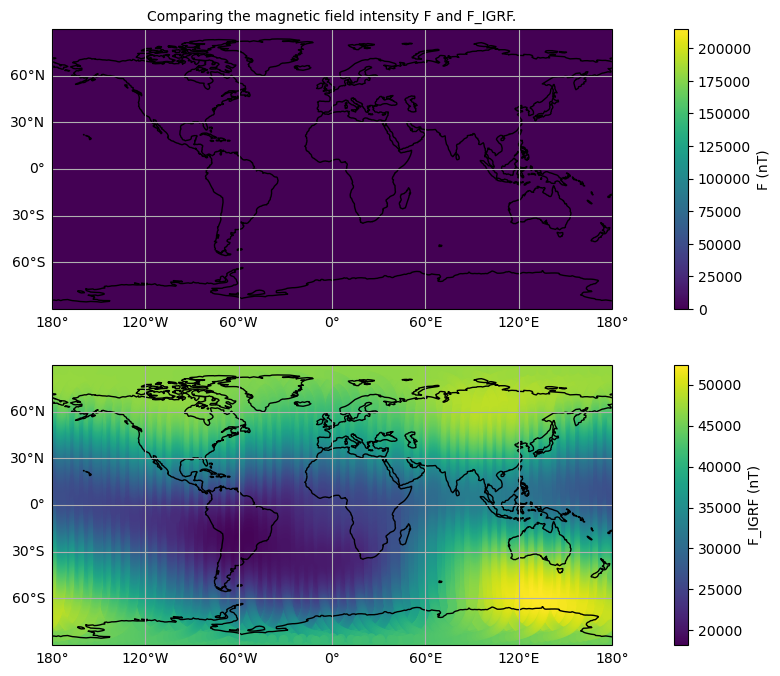

In [8]:
# Scatter plot comparing the measurements "F" and "F_IGR".
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax1.coastlines()
ax2.coastlines()
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False
gl.right_labels=False
gm = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gm.top_labels=False
gm.right_labels=False

ax1.set_title('Comparing the magnetic field intensity F and F_IGRF.', fontsize=10)

absolute_field = ax1.scatter(data_swarm["Longitude"],data_swarm["Latitude"], c=(data_swarm["F"]), transform=ccrs.PlateCarree())
absolute_field_IGRF = ax2.scatter(data_swarm["Longitude"],data_swarm["Latitude"], c=(data_swarm["F_IGRF"]), transform=ccrs.PlateCarree())
fig.colorbar(absolute_field, ax=ax1,label="F (nT)")
fig.colorbar(absolute_field_IGRF, ax=ax2,label="F_IGRF (nT)")

We observe that most datapoints are zero or empty for "F" and also that some datapoints are much higher than the expected maximum of roughly 55000 NT.
These empty columns and outliners can cause problems when using this data for many forms of calculations and should be looked at accordingly.
The outliners can potentially be avaioded by also downloading auxilliary measurements like "F_error" to flag the data. In this simple example we will just drop the empty columns and only use dataponts below a reasonable value of 55000 nT.

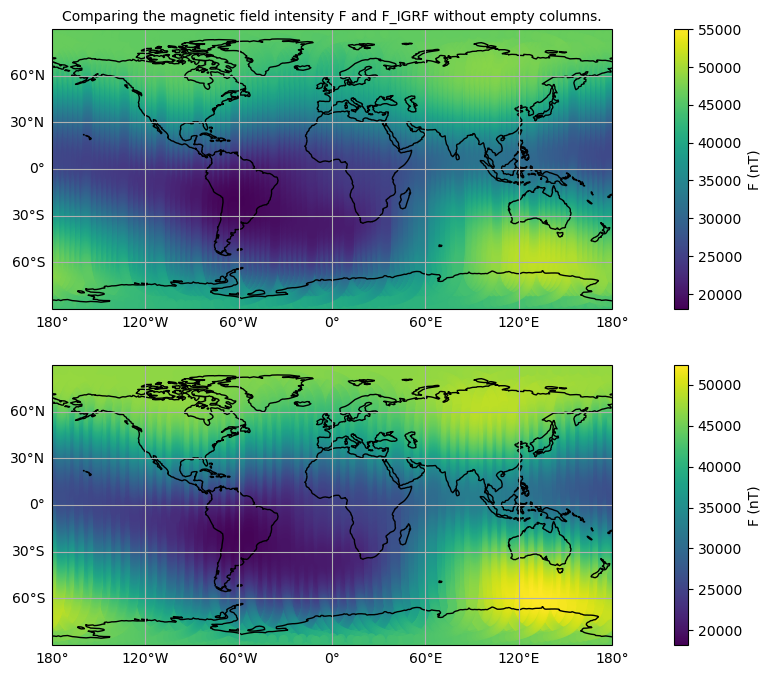

In [9]:
# Drop empty columns.
data_swarm_drop = data_swarm.where(data_swarm["F"]!=0)

# Scatter plot comparing the measurements "F" and "F_IGR".
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax1.coastlines()
ax2.coastlines()
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False
gl.right_labels=False
gm = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gm.top_labels=False
gm.right_labels=False

ax1.set_title('Comparing the magnetic field intensity F and F_IGRF without empty columns.', fontsize=10)

# Set the maximum value to 5500 nT.
absolute_field = ax1.scatter(data_swarm_drop["Longitude"],data_swarm_drop["Latitude"], c=(data_swarm_drop["F"]), vmax=55000, transform=ccrs.PlateCarree())
absolute_field_IGRF = ax2.scatter(data_swarm["Longitude"],data_swarm["Latitude"], c=(data_swarm["F_IGRF"]), transform=ccrs.PlateCarree())
fig.colorbar(absolute_field, ax=ax1,label="F (nT)")
fig.colorbar(absolute_field_IGRF, ax=ax2,label="F (nT)")

Now the bareley processed sattelite data "F" looks much closer to the model data "F_IGRF", one can even see the South Atlantic Anomaly.

This approach to quality control obviously doesn't work for much larger data sizes as it is ´far to slow, but it should atleast give the reader an idea of what to lookout for when working with Swarm data. Explicitly this would mean dropping the empty columns as done above and use the auxilliary measurements to flag the outliners

In [10]:
# Show total run time.
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.1f} seconds")

Execution time: 136.0 seconds
